# Threshold Caliberation and Model Testing

#### Here, we caliberate the best model - 5 layer deep CNN with GlobalMaxPooling at 7th epoch

#### In this notebook, we do the following :-
1. Define the model architecture and load its weights at 7th epoch
2. Plot its precision-recall curve to analyze their trade-off with increasing threshold
3. Set the threshold for which recall >90% on the validation set and see the corresponding precision
4. Get the performance metrics on the test set using the set threshold

#### Conclusion :-
<b>On test set, we get the AUC of 0.89 with the precision of 54% on 89% recall! </b> 


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score,roc_auc_score,precision_score,recall_score


# Load the Final Model

In [4]:
downsize_ratio = 4
IMG_SIZE = int(1024 / downsize_ratio)
batch_size = 12

In [5]:
#CNN Layers
def convolutional_block_5layer(inputs):
    #1
    x = Conv2D(60, (3,3), padding = 'same')(inputs) #254 x 254 x 30 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x) #127 x 127 x 30
    
    #2
    x = Conv2D(120, (3,3), padding = 'same')(x) #125 x 125 x 60
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x) #62 x 62 x 60

    #3
    x = Conv2D(240, (3,3), padding = 'same')(x) #60 x 60 x 120
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x) #30 x 30 x 120

    #4
    x = Conv2D(480, (3,3),  padding = 'same')(x) #28 x 28 x 240
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x) #14 x 14 x 240

    #5
    x = Conv2D(960, (3,3),  padding = 'same')(x) #12 x 12 x 960
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3))(x) #6 x 6 x 240
    
    return x

def classification_block_5layer(x):

    x = Dropout(0.2)(x)

    x = Dense(200)(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    x = Dense(50)(x)
    x = ReLU()(x)
    
    x = Dense(1, activation = 'sigmoid', name = 'classification')(x)

    return x

inputs = Input(shape = (IMG_SIZE,IMG_SIZE,1))
convolutional_block_x = convolutional_block_5layer(inputs)
fc_block = GlobalMaxPooling2D()(convolutional_block_x) #Global Max Pooling
classification_block_maxpool = classification_block_5layer(fc_block)
l5_maxglobalpool_model = Model(inputs = inputs, outputs = classification_block_maxpool)


In [86]:
#Load Weights
weights_path = 'final_models/L5_max_pool_v2/L5_max_pool_v2_07.keras' #7th epoch
l5_maxglobalpool_model.load_weights(weights_path)


# Create Validation and Test Pipeline

In [87]:
validation_df = pd.read_csv('Data/pneumonia/val_metadata.csv')
validation_df['file_path'] = 'Data/pneumonia/Training/Images/' + validation_df['patientId'] + '.png'
validation_data = list(zip(validation_df['file_path'], validation_df['Target']))
validation_paths, validation_target = zip(*validation_data)

def load_and_process_validation(image_path, target):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method = 'bilinear')
    image = tf.cast(image, tf.float32)
    return image, target

val_ds = tf.data.Dataset.from_tensor_slices((list(validation_paths),  list(validation_target)))
val_ds = val_ds.map(load_and_process_validation, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:

test_df = pd.read_csv('Data/pneumonia/test_metadata.csv')
test_df['file_path'] = 'Data/pneumonia/Training/Images/' + test_df['patientId'] + '.png'
test_df = list(zip(test_df['file_path'], test_df['Target']))
test_paths, test_target = zip(*test_df)

test_ds = tf.data.Dataset.from_tensor_slices((list(test_paths),  list(test_target)))
test_ds = test_ds.map(load_and_process_validation, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Plot Precision - Recall Curve

In [88]:
y_prob = l5_maxglobalpool_model.predict(val_ds) #Prediction on Validation Set
y_true = validation_target #True labels on Validation Set

188/188 [==============================] - 12s 62ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


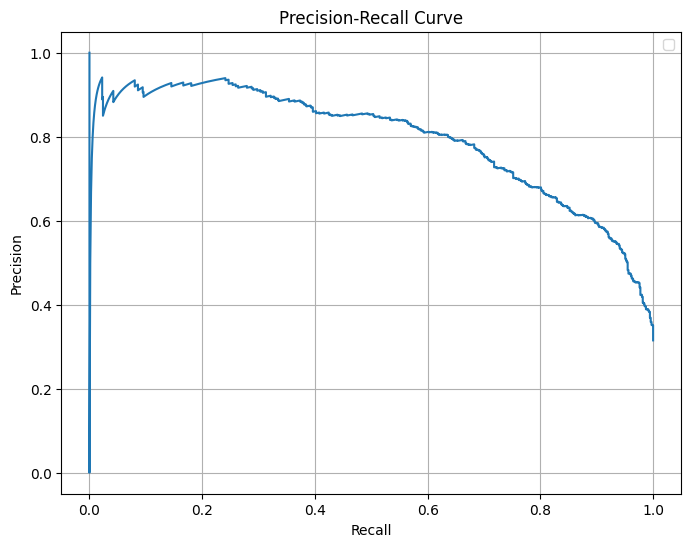

In [91]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
thresholds_v2 = np.append(thresholds,1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

We can see that as the threshold for positive class decreases from left to right, precision gets lower and recall gets higher as expected!

Since this is a model to "suggest" pneumonia presence, the threshold should be caliberated such that recall is higher (>90%) given satisfactory precision!

# Caliberate Threshold s.t. Recall >90%

In [93]:
pr_curve_df = pd.DataFrame(data = {'threshold': thresholds_v2, 'precision': precision, 'recall': recall})
pr_curve_df.sort_values('threshold', ascending = False, inplace = True)
pr_curve_df[pr_curve_df['recall']>=0.9].head(10)

,threshold,precision,recall
1172,0.283277,0.593866,0.901269
1171,0.283217,0.593315,0.901269
1170,0.282977,0.593692,0.902680
1169,0.281777,0.593142,0.902680
1168,0.280520,0.592593,0.902680
1167,0.280499,0.592044,0.902680
1166,0.279914,0.591497,0.902680
1165,0.278932,0.590951,0.902680
1164,0.278737,0.590406,0.902680
1163,0.278426,0.589862,0.902680


Hence, if we set our threshold to 0.283, we get recall of 90% with the precision of 59% on the validation set!

In [ ]:
calibrated_threshold = 0.283

# Testing the Final Model

In [96]:
y_prob_test = l5_maxglobalpool_model.predict(test_ds)
y_true_test = test_target

188/188 [==============================] - 12s 63ms/step


In [97]:

def evaluate_model(y_true, y_probs, threshold=0.5):

    y_true = np.array(y_true)
    y_probs = np.array(y_probs).flatten()
    y_pred = (y_probs >= threshold).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_probs),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
    }

    return metrics


In [98]:
evaluate_model(y_true_test, y_prob_test, calibrated_threshold)

{'Accuracy': 0.7448888888888889,
 'AUC': 0.8795017314624036,
 'Precision': 0.544211485870556,
 'Recall': 0.8897168405365127}

# Performance on Testing Set
1. On testing set, we got the AUC of 0.87. This is good!
2. However, we got the precision of 54% on the recall of 89%!
3. In the improved model, we should aim to increase the precision of the model while keeping the higher recall (>90%) to suit clinical needs to aid radiologists